In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from comet_ml import Experiment
from dotenv import load_dotenv
import xgboost as xgb
import matplotlib.ticker as mtick
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_auc_score, roc_curve
import copy
import os
import seaborn as sns
load_dotenv()


True

In [2]:
df = pd.read_csv(os.getenv("MODEL_DATA_PATH"), index_col=0)
df = df.dropna()
train_label = df['isgoal']
train_data = df.drop(['isgoal', 'attackingSide', 'periodTime'], axis=1)

In [3]:
train_data['is_rebound'].replace({False: 0, True: 1}, inplace=True)


In [4]:
train_data = pd.get_dummies(train_data, columns=['last_event_type', 'shotType'] , dtype=np.int32, drop_first=True)

In [5]:
train_data_min = train_data.min()
train_data_max = train_data.max()
train_data = (train_data - train_data_min) / (train_data_max - train_data_min) # min-max scaling


In [6]:

# Define the hyperparameter grid
param_grid = {
    'objective': ['binary:logistic'],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100],
    'reg_alpha': [0.1, 0.001]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc')

# Fit the GridSearchCV object to the training data
grid_search.fit(train_data, train_label)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'objective': 'binary:logistic', 'reg_alpha': 0.1}
Best score:  0.7726421424079819


In [8]:
cv    = RepeatedKFold(n_splits=5, n_repeats=100, random_state=101)
folds = [(train,val) for train, val in cv.split(train_data, train_label)]
metrics = ['auc', 'fpr', 'tpr', 'thresholds', 'probabilities', 'labels']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
}

In [9]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 7,
    'learning_rate': 0.1,
    'reg_alpha': 0.1,
}

In [10]:
for train, val in tqdm(folds, total=len(folds)):
    dtrain = xgb.DMatrix(train_data.iloc[train,:], label=train_label.iloc[train])
    dval   = xgb.DMatrix(train_data.iloc[val,:], label=train_label.iloc[val])
    model  = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round       = 1000,
        verbose_eval          = False,
        early_stopping_rounds = 10,
    )
    sets = [dtrain, dval]
    for i,ds in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))
        results[ds]['probabilities'].append(y_preds)
        results[ds]['labels'].append(labels)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
kind = 'val'
c_fill      = 'rgba(52, 152, 219, 0.2)'
c_line      = 'rgba(52, 152, 219, 0.5)'
c_line_main = 'rgba(41, 128, 185, 1.0)'
c_grid      = 'rgba(189, 195, 199, 0.5)'
c_annot     = 'rgba(149, 165, 166, 0.5)'
c_highlight = 'rgba(192, 57, 43, 1.0)'
fpr_mean    = np.linspace(0, 1, 100)
interp_tprs = []
for i in range(100):
    fpr           = results[kind]['fpr'][i]
    tpr           = results[kind]['tpr'][i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = 2*np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std
auc          = np.mean(results[kind]['auc'])
fig = go.Figure([
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_upper,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_lower,
        fill       = 'tonexty',
        fillcolor  = c_fill,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'lower'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_mean,
        line       = dict(color=c_line_main, width=2),
        hoverinfo  = "skip",
        showlegend = True,
        name       = f'AUC: {auc:.3f}')
])
fig.add_shape(
    type ='line', 
    line =dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template    = 'plotly_white', 
    title_x     = 0.5,
    xaxis_title = "1 - Specificity",
    yaxis_title = "Sensitivity",
    width       = 800,
    height      = 800,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=0.95,
        y=0.01,
    )
)
fig.update_yaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black')
fig.update_xaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black')

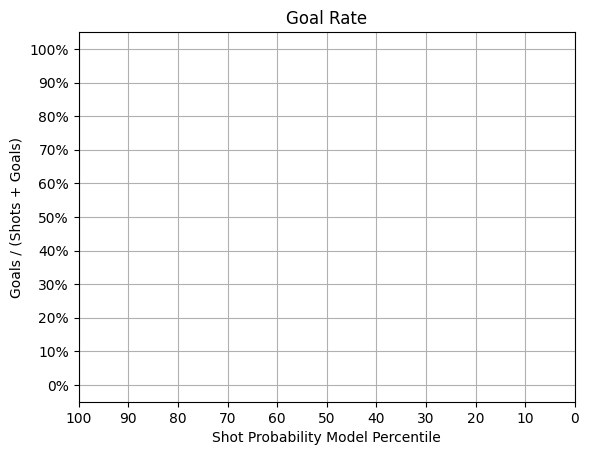

In [ ]:
goal_rate_mean = []
for i in range(len(results['val']['probabilities'])):
    df = pd.DataFrame({'isgoal':results['val']['labels'][i], 'probabilities':results['val']['probabilities'][i]})
    # calculate shot probability model percentile for each shot
    df['percentile'] = df['probabilities'].rank(pct=True)
    # group shots by percentile and calculate goal rate for each group
    goal_rates = df.groupby(pd.cut(df['percentile'], bins=[0]+[i/10 for i in range(1, 11)], include_lowest=True), observed=False)['isgoal'].mean()
    goal_rate_mean.append(goal_rates)

goal_rate_mean = np.array(goal_rate_mean).mean(axis=0)
goal_rates_mid = []
for i in range(len(goal_rates.index)):
    goal_rates_mid.append(goal_rates.index[i].mid)

# plot the goal rates as a function of the shot probability model percentile
plt.plot(np.array(goal_rates_mid) * 100, goal_rate_mean)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 110, 10))
plt.gca().invert_xaxis()  # invert the x-axis
plt.xlabel('Shot Probability Model Percentile')
plt.title('Goal Rate')
plt.ylabel('Goals / (Shots + Goals)')
plt.grid(True)
plt.show()

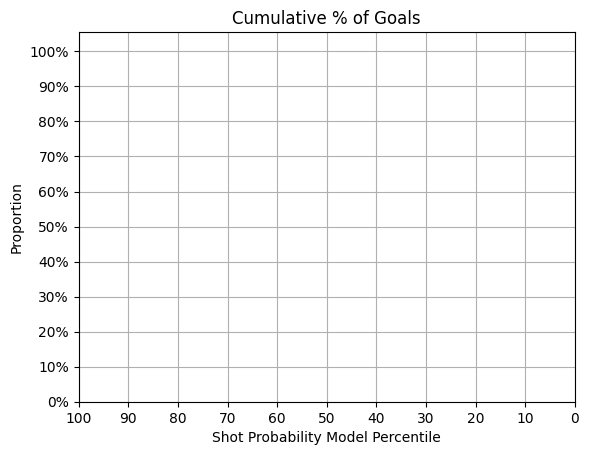

In [ ]:
goal_rate_mean = []
for i in range(len(results['val']['probabilities'])):
    df = pd.DataFrame({'isgoal':results['val']['labels'][i], 'probabilities':results['val']['probabilities'][i]})
    # calculate shot probability model percentile for each shot
    df['percentile'] = df['probabilities'].rank(pct=True)
    # group shots by percentile and calculate goal rate for each group
    goal_rates = df.groupby(pd.cut(df['percentile'], bins=[0]+[i/10 for i in range(1, 11)], include_lowest=True), observed=False)['isgoal'].mean()
    # Calculate the frequency and percentage of goals for each group
    goal_freq = goal_rates * goal_rates.index.to_series().apply(lambda x: x.length)
    goal_perc = goal_freq / goal_freq.sum()
    # cum_goal_perc = goal_perc.cumsum(axis=0)
    cum_goal_perc = np.cumsum(goal_perc[::-1])[::-1]
    goal_rate_mean.append(cum_goal_perc)
    
goal_rate_mean = np.array(goal_rate_mean).mean(axis=0)
goal_rates_mid = []
for i in range(len(goal_rates.index)):
    goal_rates_mid.append(goal_rates.index[i].mid)

# plot the goal rates as a function of the shot probability model percentile
plt.plot(np.array(goal_rates_mid) * 100, goal_rate_mean)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 110, 10))
plt.gca().invert_xaxis()  # invert the x-axis
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Proportion')
plt.title('Cumulative % of Goals')
plt.grid(True)
plt.show()

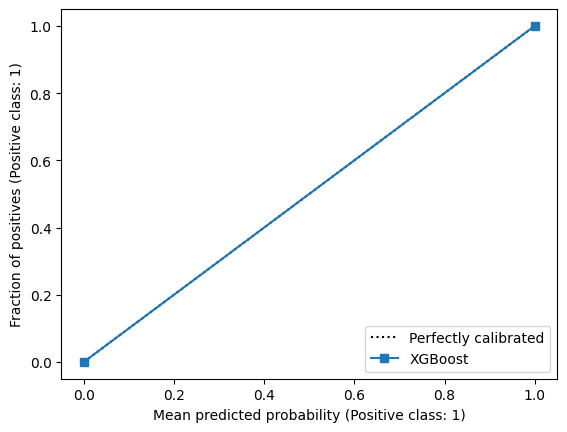

In [ ]:
y_prob = np.array(results['val']['probabilities']).flatten()
y_true = np.array(results['val']['labels']).flatten()
disp = CalibrationDisplay.from_predictions(y_true, y_prob, n_bins=10, name='XGBoost', strategy='uniform')
plt.show()

In [56]:
train_df = pd.read_csv('../Dataset/train.csv', index_col=0)
train_df = train_df.dropna()
train_label = train_df['isgoal']
train_data = train_df.iloc[:,17:].drop(['isgoal'], axis=1)
train_data['is_rebound'].replace({False: 0, True: 1}, inplace=True)
train_data = pd.get_dummies(train_data, columns=['last_event_type', 'strength'] , dtype=np.int32, drop_first=True)
train_data_min = train_data.min()
train_data_max = train_data.max()
train_data = (train_data - train_data_min) / (train_data_max - train_data_min) # min-max scaling
train_data = train_data.drop(columns=['isEmptyNet'], axis=1)

In [57]:
test_df = pd.read_csv('../Dataset/test.csv', index_col=0)
test_df = test_df.dropna()
test_label = test_df['isgoal']
test_data = test_df.iloc[:,17:].drop(['isgoal'], axis=1)
test_data['is_rebound'].replace({False: 0, True: 1}, inplace=True)
test_data = pd.get_dummies(test_data, columns=['last_event_type', 'strength'] , dtype=np.int32, drop_first=True)
test_data = (test_data - train_data_min) / (train_data_max - train_data_min) # min-max scaling
test_data = test_data.drop(columns=['isEmptyNet'], axis=1)

In [67]:
test_data = test_data.reindex(columns=train_data.columns)


In [58]:
dtrain = xgb.DMatrix(train_data, label=train_label)
dtest = xgb.DMatrix(test_data, label=test_label)

In [59]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.5,
    'reg_alpha': 0.1,
    'gamma': 0.1,
}

In [60]:
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    metrics='logloss',
    early_stopping_rounds=10,
    stratified=True,
    seed=42
)

best_num_boost_rounds = cv_results.shape[0] - 1
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_rounds,
    verbose_eval=False
)


In [ ]:
y_preds = model.predict(dtest)

In [45]:
predictions = y_preds > 0.5

In [49]:
predictions = predictions.astype(int)

In [51]:
np.mean(predictions == test_label)

1.0